In [58]:
import pandas as pd
import numpy as np
import os
import pickle
from scipy.stats import norm
from scipy.optimize import fsolve
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import least_squares
from datetime import datetime
import matplotlib.pyplot as plt

In [59]:
## read OIS excel sheet 
file_path = os.path.abspath("data/IR Data.xlsx")
df_ois = pd.read_excel(file_path, sheet_name="OIS", usecols=[0,1,2])

# convert tenor to years 
tenor_mapping = {
    '6m': 0.5,
    '1y': 1,
    '2y': 2,
    '3y': 3,
    '4y': 4,
    '5y': 5,
    '7y': 7,
    '10y': 10,
    '15y': 15,
    '20y': 20,
    '30y': 30
}

df_ois['Tenor'] = df_ois['Tenor'].map(tenor_mapping)
df_ois['Tenor_Delta'] = df_ois['Tenor'].diff().fillna(0.5)
df_ois

,Tenor,Product,Rate,Tenor_Delta
0,0.5,OIS,0.00250,0.5
1,1.0,OIS,0.00300,0.5
2,2.0,OIS,0.00325,1.0
3,3.0,OIS,0.00335,1.0
4,4.0,OIS,0.00350,1.0
5,5.0,OIS,0.00360,1.0
6,7.0,OIS,0.00400,2.0
7,10.0,OIS,0.00450,3.0
8,15.0,OIS,0.00500,5.0
9,20.0,OIS,0.00525,5.0


In [60]:
## read IRS excel sheet 
irs_df = pd.read_excel(file_path, sheet_name="IRS", usecols=[0,1,2])
irs_df  

,Tenor,Product,Rate
0,6m,LIBOR,0.0250
1,1y,IRS,0.0280
2,2y,IRS,0.0300
3,3y,IRS,0.0315
4,4y,IRS,0.0325
5,5y,IRS,0.0330
6,7y,IRS,0.0350
7,10y,IRS,0.0370
8,15y,IRS,0.0400
9,20y,IRS,0.0450


In [61]:
## read libor discount curve & ois pckl files 
libor_curve = pickle.load(open("data/libor_discount_curve.pkl", "rb"))
ois_discount_curve = pickle.load(open("data/ois_discount_curve.pkl", "rb"))

In [62]:
## read forward swap rates based on ann's codes
file_path_swap = os.path.abspath("data/swap_rates.xlsx")
forward_swap_rates = pd.read_excel(file_path_swap)
forward_swap_rates.rename(columns={'Unnamed: 0':'Expiry'}, inplace=True)
forward_swap_rates = forward_swap_rates.set_index('Expiry')
forward_swap_rates.columns.name = 'Tenor'

forward_swap_rates

Tenor,1,2,3,5,10
Expiry,,,,,
1,0.032007,0.033259,0.034011,0.035255,0.038428
5,0.039274,0.040075,0.040072,0.041093,0.043634
10,0.042189,0.043116,0.044097,0.046249,0.053458


In [63]:
r = np.arange(0.5, 20.5, 0.5)
interpolated_libors = libor_curve(r)
interpolated_ois = ois_discount_curve(r)
interpolated_ois_df = pd.DataFrame({
    'Tenor': r,
    'OIS_Discount_Factor': interpolated_ois,
    'Forward_Libor_Rates': interpolated_libors
    })

interpolated_ois_df = interpolated_ois_df.set_index('Tenor')
interpolated_ois_df.head()

,OIS_Discount_Factor,Forward_Libor_Rates
Tenor,,
0.5,0.998752,0.987654
1.0,0.997009,0.972577
1.5,0.995270,0.957378
2.0,0.993531,0.942179
2.5,0.991773,0.926330


In [64]:
## daily compounded overnight rate 
def calc_compounded_on_rate(f_t, delta_T):
    """
    calculate the daily compounded return based on the overnight rate

    Args:
    f_t(float): overnight rate
    T(float): tenor

    Returns:
    compounded overnight rate
    """
    return 1 / ((1 + f_t/360) ** (360 * delta_T))

## discount factor 
def calc_discount_factor(prev_df, f_t, delta_T):
    """
    calculate the discount factor for a given tenor

    Args:
    prev_df(float): previous discount factor
    f_t(float): overnight rate
    delta_T(float): time difference

    Returns:
    discount factor
    """
    return prev_df * calc_compounded_on_rate(f_t, delta_T)

## forward libor rate 
def calc_forward_libor(prev_df, current_df, delta_T):
    """
    calculate the forward libor rate for a given tenor

    Args:
    prev_df(float): previous discount factor
    current_df(float): current discount factor
    delta_T(float): time difference

    Returns:
    forward libor rate
    """
    return (1/delta_T) *(prev_df/current_df - 1)

In [65]:
## black 76 model 
class black_76_model:
    def __init__(self, F: float, K: float, sigma: float, discount_factor: float, T: float):
        self.F = F
        self.K = K
        self.sigma = sigma
        self.discount_factor = discount_factor
        self.T = T
        self.d1 = self.calc_black_scholes_d1()
        self.d2 = self.calc_black_scholes_d2()

    def calc_black_scholes_d1(self) -> float:
        sigma_sqrt_time = self.sigma * np.sqrt(self.T)
        return (np.log(self.F / self.K) + (np.power(self.sigma, 2)/2) * self.T ) / sigma_sqrt_time
    
    def calc_black_scholes_d2(self) -> float:
        sigma_sqrt_time = self.sigma * np.sqrt(self.T)
        return self.d1 - sigma_sqrt_time
    
    def blackscholes_call(self):
        return self.discount_factor*(self.F*norm.cdf(self.d1) - self.K*norm.cdf(self.d2))

    def blackscholes_put(self):
        return self.discount_factor*(self.F*norm.cdf(-self.d1) + self.K*norm.cdf(-self.d2))

In [66]:
## SABR model
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma     

In [67]:
## read sabr params data and pre-process
file_path_sabr = os.path.abspath("data/sabr_calibrated.xlsx")
df_sabr_alpha = pd.read_excel(file_path_sabr, sheet_name="sabr_alpha")
df_sabr_rho = pd.read_excel(file_path_sabr, sheet_name="sabr_rho")
df_sabr_nu = pd.read_excel(file_path_sabr, sheet_name="sabr_nu")

def prep_sabr_params(df):
    df = df.rename(columns = {'Unnamed: 0': 'Expiry'})
    df.set_index('Expiry', inplace=True)
    df.columns.name = 'Tenors'
    return df

df_sabr_alpha = prep_sabr_params(df_sabr_alpha)
df_sabr_rho = prep_sabr_params(df_sabr_rho)
df_sabr_nu = prep_sabr_params(df_sabr_nu)

print("=============== df_sabr_alpha ====================")
print(df_sabr_alpha)
print("=============== df_sabr_rho =============== ")
print(df_sabr_rho)
print("===============df_sabr_nu =============== ")
print(df_sabr_nu)

=============== df_sabr_alpha ====================
Tenors        1Y        2Y        3Y        5Y       10Y
Expiry                                                  
1Y      0.139104  0.184643  0.196771  0.177927  0.172890
5Y      0.166455  0.198386  0.199951  0.188062  0.171354
10Y     0.178394  0.193247  0.196821  0.192991  0.178947
=============== df_sabr_rho =============== 
Tenors        1Y        2Y        3Y        5Y       10Y
Expiry                                                  
1Y     -0.633006 -0.525086 -0.482617 -0.413643 -0.309788
5Y     -0.585134 -0.543885 -0.517960 -0.495742 -0.397162
10Y    -0.548809 -0.540522 -0.527671 -0.540684 -0.512736
===============df_sabr_nu =============== 
Tenors        1Y        2Y        3Y        5Y       10Y
Expiry                                                  
1Y      2.048783  1.677390  1.438554  1.066044  0.760416
5Y      1.339865  1.062308  0.946712  0.683542  0.543337
10Y     1.010698  0.924579  0.860870  0.723664  0.601515


In [68]:
## interpolation of sabr params 
expiry_range = np.arange(0.25, 10.25, 0.25) # quarterly expiry range

def sabr_params_interp(df):
    interpolated_values = {}

    for tenor in df.columns:
        interp = interpolate.interp1d(
            df.index.str.replace('Y', '').astype(float), 
            df[tenor].astype(float),
            kind='linear', 
            fill_value='extrapolate'
            )
    
        interpolated_values[tenor] = interp(expiry_range)
    return pd.DataFrame(interpolated_values, index=expiry_range)


df_sabr_alpha_interp = sabr_params_interp(df_sabr_alpha)
df_sabr_rho_interp = sabr_params_interp(df_sabr_rho)
df_sabr_nu_interp = sabr_params_interp(df_sabr_nu)
df_sabr_alpha_interp.head()



,1Y,2Y,3Y,5Y,10Y
0.25,0.133975,0.182066,0.196175,0.176027,0.173178
0.50,0.135685,0.182925,0.196374,0.176660,0.173082
0.75,0.137394,0.183784,0.196573,0.177294,0.172986
1.00,0.139104,0.184643,0.196771,0.177927,0.172890
1.25,0.140813,0.185502,0.196970,0.178561,0.172794


In [69]:
## CMS rates calculation
def IRR_0(K, m, N):
    """
    Implementation of IRR(K) function 

    Args:
    K(float): strike rate
    m(float): tenor
    N(float): number of periods
    """
    value = 1/K * ( 1.0 - 1/(1 + K/m)**(N*m) )
    return value

def IRR_1(K, m, N):
    """
    Implementation of IRR'(K) function (1st derivative)
    """
    firstDerivative = -1/K*IRR_0(K, m, N) + 1/(K*m)*N*m/(1+K/m)**(N*m+1)
    return firstDerivative

def IRR_2(K, m, N):
    """ 
    Implementation of IRR''(K) function (2nd derivative)
    """
    secondDerivative = -2/K*IRR_1(K, m, N) - 1/(K*m*m)*(N*m)*(N*m+1)/(1+K/m)**(N*m+2)
    return secondDerivative


def g_0(K):
    """ 
    Implementation of g(K) function
    """
    return K

def g_1(K):
    """
    Implementation of g'(K) function (1st derivative)
    """
    return 1.0

def g_2(K):
    """
    Implementation of g''(K) function (2nd derivative)
    """
    return 0.0

def h_0(K, m, N):
    """ 
    Implementation of h(K) function
    """
    value = g_0(K) / IRR_0(K, m, N)
    return value

def h_1(K, m, N):
    """ 
    Implementation of h'(K) function (1st derivative)
    """
    firstDerivative = (IRR_0(K, m, N)*g_1(K) - g_0(K)*IRR_1(K, m, N)) / IRR_0(K, m, N)**2
    return firstDerivative

def h_2(K, m, N):
    """ 
    Implementation of h''(K) function (2nd derivative)
    """
    secondDerivative = ((IRR_0(K, m, N)*g_2(K) - IRR_2(K, m, N)*g_0(K) - 2.0*IRR_1(K, m, N)*g_1(K))/IRR_0(K, m, N)**2 
                        + 2.0*IRR_1(K, m, N)**2*g_0(K)/IRR_0(K, m, N)**3)
    return secondDerivative

In [70]:
## IRR settled option price 
def irr_settled_option_price(F, discount_factor, K, sigma, T, m, N, swap_type):
    """
    Calculate the price of an IRR-settled swaption using the Black-76 model

    Parameters:
        F (float): forward swap rate
        discount_factor (float): discount factor
        K (float): strike
        sigma (float): volatility
        T (float): time to expiry
        m (int): number of payments per year
        N (int): Tenor
        swap_type (str): Type of swap (Payer or Receiver).

    Returns:
        float: Option price.
    """
    irr_0 = IRR_0(F, m, N)
    df_numeraire = 1  # discount factor D(t,T) = 1
    black76_model = black_76_model(F, K, sigma, df_numeraire, T)
    if swap_type == 'payer':
        option_price = black76_model.blackscholes_call()
    elif swap_type == 'receiver':
        option_price = black76_model.blackscholes_put()
    else: 
        raise NameError("Invalid swap type.")
    return discount_factor * irr_0 * option_price

In [71]:
Expiry = [1, 5, 10]
Tenors = [1, 2, 3, 5, 10]
cms_rate = pd.DataFrame(np.zeros((len(Expiry), len(Tenors))), index=Expiry, columns=Tenors)
cms_rate

,1,2,3,5,10
1,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0


In [72]:
## interpolation of forward swap rates
expiry_range = np.arange(0.25, 10.25, 0.25) # quarterly expiry range

def interploate_df(df):
    interpolated_values = {}

    for tenor in df.columns:
        interp = interpolate.interp1d(
            df.index,
            df[tenor].astype(float),
            kind='linear', 
            fill_value='extrapolate'
            )
    
        interpolated_values[tenor] = interp(expiry_range)
    return pd.DataFrame(interpolated_values, index=expiry_range)

forward_swap_df_interp = interploate_df(forward_swap_rates)
forward_swap_df_interp.head(5)

,1,2,3,5,10
0.25,0.030644,0.031981,0.032874,0.034161,0.037452
0.50,0.031099,0.032407,0.033253,0.034526,0.037777
0.75,0.031553,0.032833,0.033632,0.034891,0.038103
1.00,0.032007,0.033259,0.034011,0.035255,0.038428
1.25,0.032461,0.033685,0.034390,0.035620,0.038753


In [73]:
## Interpoation of OIS discount factionrs
full_range = np.arange(0.25,20.5,0.25)

interp_ois = interpolate.interp1d(
    interpolated_ois_df.index,
    interpolated_ois_df["OIS_Discount_Factor"],
    kind='linear',
    fill_value='extrapolate'
)

new_interp_ois_df = pd.DataFrame({'T': interp_ois(full_range)}, index=full_range)
new_interp_ois_df.head(5)

,T
0.25,0.999623
0.50,0.998752
0.75,0.997880
1.00,0.997009
1.25,0.996139


In [74]:
def calc_cms_rate(F, m, N, T):
    alpha = df_sabr_alpha_interp.loc[T, f"{N}Y"]
    beta = 0.9
    rho = df_sabr_rho_interp.loc[T, f"{N}Y"]
    nu = df_sabr_nu_interp.loc[T, f"{N}Y"]  
    discount_factor = new_interp_ois_df.loc[T]["T"]

    atm_vol = SABR(F,F,T,alpha, beta, rho, nu)
    maxK = F * np.exp(4 * atm_vol * np.sqrt(T))
    integrand_receive = quad(lambda k: h_2(k, m, N)*irr_settled_option_price(F, 
                                                                                discount_factor,
                                                                                k,
                                                                                SABR(F,k,T,alpha, beta, rho, nu),
                                                                                T, 
                                                                                m, 
                                                                                N, 
                                                                                'receiver'), 
                                                                                1e-6, # lower bound close to 0
                                                                                F, 
                                                                                limit=100
                                                                                )
                                                                                
    integrand_pay = quad(lambda k: h_2(k, m, N)*irr_settled_option_price(F, 
                                                                            discount_factor, 
                                                                            k, 
                                                                            SABR(F,k,T,alpha, beta, rho, nu),
                                                                            T, 
                                                                            m, 
                                                                            N, 
                                                                            'payer'), 
                                                                            F, 
                                                                            maxK, # upper bound instead of np.inf
                                                                            limit=100 # subintervals
                                                                            )
    return g_0(F) + integrand_pay[0] + integrand_receive[0]

In [75]:
for expiry in Expiry:
    for tenor in Tenors:
        F = forward_swap_rates.loc[expiry, tenor]
        T = expiry
        m = 2
        N = tenor        
        cms_rate.loc[expiry, tenor] = calc_cms_rate(F, T, m, N)

print(cms_rate)

          1         2         3         5         10
1   0.033014  0.035318  0.037987  0.043714  0.114658
5   0.040394  0.042291  0.044241  0.050182  0.134110
10  0.043421  0.045556  0.048883  0.057192  0.182388


In [76]:
print(forward_swap_rates)

Tenor          1         2         3         5        10
Expiry                                                  
1       0.032007  0.033259  0.034011  0.035255  0.038428
5       0.039274  0.040075  0.040072  0.041093  0.043634
10      0.042189  0.043116  0.044097  0.046249  0.053458


# Calculating PV of CMS Leg

In [77]:
## PV of a leg receiving CMS10y semi-annually over the next 5 years
pv = 0

# todo, interploate foward_swap_rates
for start in np.arange(0.5, 5, 0.5):
    disc_factor = interpolated_ois_df.loc[start]["OIS_Discount_Factor"]
    F = forward_swap_df_interp.loc[start, 10]
    T = start
    m = 2
    N = 10
    current_cms_rate = calc_cms_rate(F, T, m, N)
    pv += disc_factor * 0.5 * current_cms_rate
    print(f"start={start}, df={disc_factor}, cms_rate={current_cms_rate}, pv={pv}")

print(f"\n final PV={pv}")

start=0.5, df=0.9987515605493134, cms_rate=0.11873064708171856, pv=0.05929120952894809
start=1.0, df=0.9970089730807579, cms_rate=0.11465772790703657, pv=0.11644860130713183
start=1.5, df=0.9952698594970136, cms_rate=0.11550072186084602, pv=0.17392579491625576
start=2.0, df=0.9935307459132694, cms_rate=0.11750373737200932, pv=0.23229758283566043
start=2.5, df=0.9917729435657792, cms_rate=0.11994364863621192, pv=0.29177601557063815
start=3.0, df=0.9900151412182888, cms_rate=0.1225959370211094, pv=0.3524619325220092
start=3.5, df=0.9880658954667711, cms_rate=0.125371339298432, pv=0.414399504836896
start=4.0, df=0.9861166497152534, cms_rate=0.12822831474890173, pv=0.47762354290630604
start=4.5, df=0.9841503847242372, cms_rate=0.13114525266531663, pv=0.5421568683389704

 final PV=0.5421568683389704


In [78]:
## PV of a leg receiving CMS2y quarterly over the next 10 years
pv = 0

# todo, interploate foward_swap_rates
for start in np.arange(0.25, 10, 0.25):
    disc_factor = new_interp_ois_df.loc[start]["T"]
    F = forward_swap_df_interp.loc[start, 2]
    T = start
    m = 2
    N = 2
    current_cms_rate = calc_cms_rate(F, T, m, N)
    pv += disc_factor * 0.5 * current_cms_rate
    print(f"start={start}, df={disc_factor}, cms_rate={current_cms_rate}, pv={pv}")

print(f"\n final PV={pv}")

start=0.25, df=0.9996228542835911, cms_rate=0.03541262258761836, pv=0.017699633434351318
start=0.5, df=0.9987515605493134, cms_rate=0.03492148321611368, pv=0.03513857636374641
start=0.75, df=0.9978802668150356, cms_rate=0.035036332029558345, pv=0.05261960854068434
start=1.0, df=0.9970089730807579, cms_rate=0.03531803528387061, pv=0.07022580758548524
start=1.25, df=0.9961394162888857, cms_rate=0.03566954077949849, pv=0.08799172535117636
start=1.5, df=0.9952698594970136, cms_rate=0.036056989116504644, pv=0.10593494259711082
start=1.75, df=0.9944003027051416, cms_rate=0.03646546864942761, pv=0.12406557912874866
start=2.0, df=0.9935307459132694, cms_rate=0.03688738529115025, pv=0.14238995484030198
start=2.25, df=0.9926518447395243, cms_rate=0.03731846345119775, pv=0.16091207563413995
start=2.5, df=0.9917729435657792, cms_rate=0.03775611153519482, pv=0.17963482057156896
start=2.75, df=0.990894042392034, cms_rate=0.03819866700609918, pv=0.19856023635339937
start=3.0, df=0.9900151412182888, c

# Comparing difference between CMS Rate and Forward Swap Rates

In [79]:
# Difference in CMS rates
rate_diff_df = np.round((cms_rate - forward_swap_rates)*100,2)
print(rate_diff_df)

      1     2     3     5      10
1   0.10  0.21  0.40  0.85   7.62
5   0.11  0.22  0.42  0.91   9.05
10  0.12  0.24  0.48  1.09  12.89


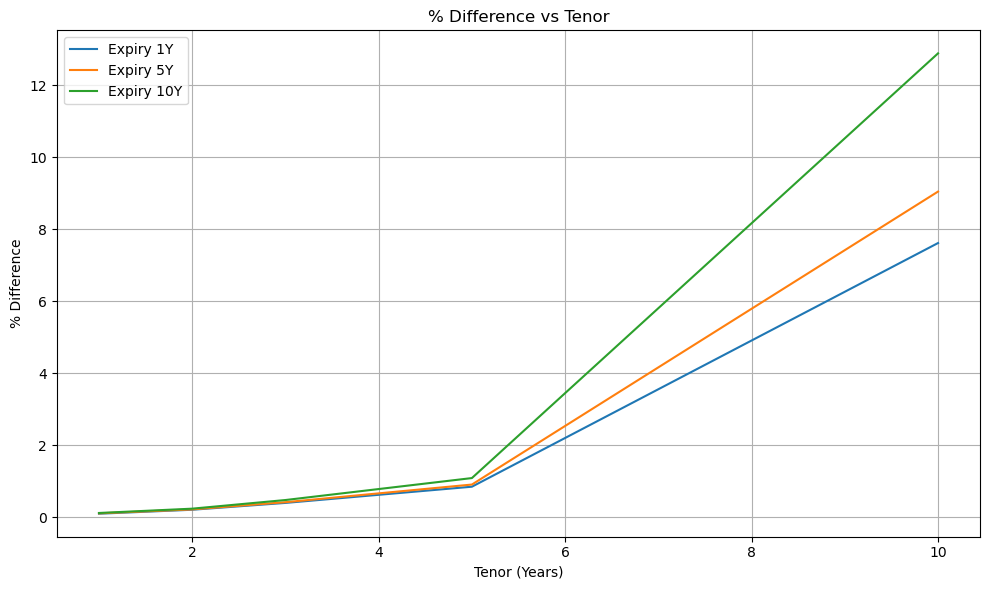

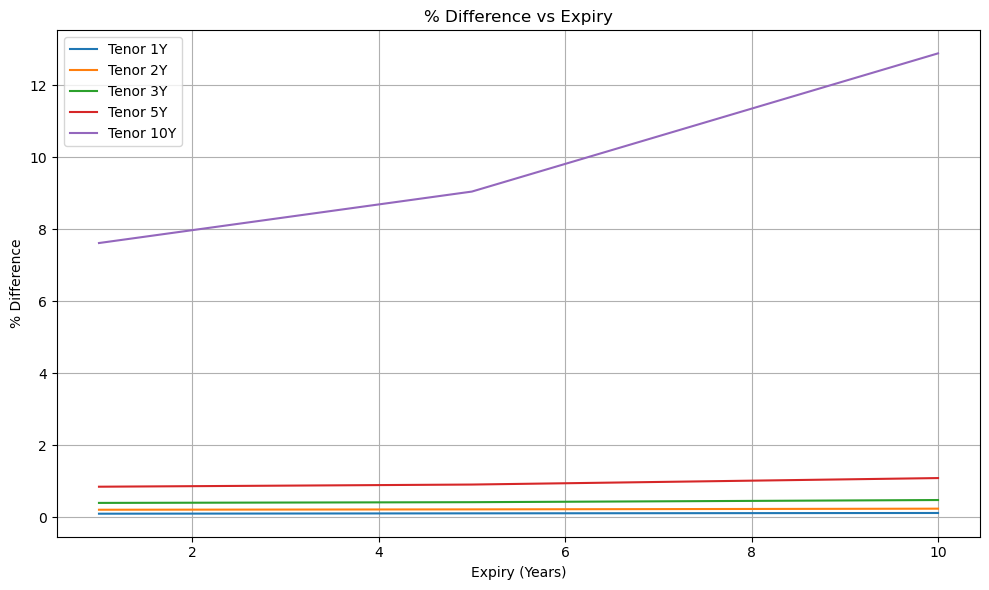

In [80]:
plt.figure(figsize=(10, 6))
for expiry in rate_diff_df.index:
    plt.plot(rate_diff_df.columns.astype(int), rate_diff_df.loc[expiry], label=f'Expiry {expiry}Y')
plt.xlabel('Tenor (Years)')
plt.ylabel('% Difference')
plt.title('% Difference vs Tenor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 3: Plot % difference vs expiry (each line is a tenor)
plt.figure(figsize=(10, 6))
for tenor in rate_diff_df.columns:
    plt.plot(rate_diff_df.index.astype(int), rate_diff_df[tenor], label=f'Tenor {tenor}Y')
plt.xlabel('Expiry (Years)')
plt.ylabel('% Difference')
plt.title('% Difference vs Expiry')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()